# Prediction of viscosity of epxoy resin and diluent at various temperatures

This model is to reproduce the result from [***Highly accurate prediction of viscosity of epoxy resin and diluent at various temperatures utilizing machine learning***](doi.org/10.1016/j.polymer.2022.125216).

Using different Machine Learning model to predict.

First import the after cleaning data from the paper.

In [20]:
import numpy as np
import pandas as pd

data = pd.read_excel("epoxy_dataset.xlsx")
# show the first five rows
data

,Temperature/℃,Epoxy Resin,Additional Group of Epoxy resin,Diluent,Additional Group of Diluent,Ratio of Epoxy Resin to Diluent,Viscosity
0,29.795191,bisphenol A,H,glycidyl ether,n-butyl,95：5,1243.068262
1,29.736358,bisphenol A,H,glycidyl ether,n-butyl,90：10,597.888811
2,29.731920,bisphenol A,H,glycidyl ether,n-butyl,85：15,368.191414
3,29.729081,bisphenol A,H,glycidyl ether,n-butyl,80：20,221.252639
4,34.840280,bisphenol A,H,glycidyl ether,n-butyl,95：5,776.917664
...,...,...,...,...,...,...,...
994,30.000000,phenolic,H,glycidyl ether,"1, 4-butanediol",100：70,600.000000
995,60.000000,phenolic,H,glycidyl ether,"1, 4-butanediol",100：30,275.000000
996,60.000000,phenolic,H,glycidyl ether,"1, 4-butanediol",100：50,200.000000
997,60.000000,phenolic,H,glycidyl ether,"1, 4-butanediol",100：60,175.000000


In [21]:
data.rename(columns={'Temperature/℃':'Temperature'}, inplace=True)
data.head(5)

,Temperature,Epoxy Resin,Additional Group of Epoxy resin,Diluent,Additional Group of Diluent,Ratio of Epoxy Resin to Diluent,Viscosity
0,29.795191,bisphenol A,H,glycidyl ether,n-butyl,95：5,1243.068262
1,29.736358,bisphenol A,H,glycidyl ether,n-butyl,90：10,597.888811
2,29.731920,bisphenol A,H,glycidyl ether,n-butyl,85：15,368.191414
3,29.729081,bisphenol A,H,glycidyl ether,n-butyl,80：20,221.252639
4,34.840280,bisphenol A,H,glycidyl ether,n-butyl,95：5,776.917664


Based on the correlation matrix, the authors decided to eliminate the Ph category from diluents.

In [22]:
data = data.drop(data[data["Diluent"] == "phenolic"].index)

## One Hot Encoding

Using One-Hot encoder method (OHE), these combinations of epoxy and diluent were turned into dummy variables.

In [23]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

LE = LabelEncoder()
datale = data
for i in range(1, 6):
    datale.iloc[:, i] = LE.fit_transform(datale.iloc[:, i])
data = datale

X_need_trans = data.iloc[:, 1:6].values
y = data.Viscosity

OHE = OneHotEncoder(categories='auto', drop='first')
X_trans = OHE.fit_transform(X_need_trans).toarray()

X = np.insert(X_trans, 0, data.iloc[:, 0].values, axis=1)

X, y

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


(array([[29.79519065,  0.        ,  0.        , ...,  0.        ,
          0.        ,  1.        ],
        [29.73635798,  0.        ,  0.        , ...,  1.        ,
          0.        ,  0.        ],
        [29.73192024,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [60.        ,  0.        ,  1.        , ...,  0.        ,
          0.        ,  0.        ],
        [60.        ,  0.        ,  1.        , ...,  0.        ,
          0.        ,  0.        ],
        [60.        ,  0.        ,  1.        , ...,  0.        ,
          0.        ,  0.        ]]),
 0      1243.068262
 1       597.888811
 2       368.191414
 3       221.252639
 4       776.917664
           ...     
 994     600.000000
 995     275.000000
 996     200.000000
 997     175.000000
 998     105.000000
 Name: Viscosity, Length: 994, dtype: float64)

## Decision Tree (DT)

In [24]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

train 80%, validation 20% of train

test 20%

random seed 0

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

10-fold cross validation

20% of train

In [26]:
X_validation, X_rest, y_validation, y_rest = train_test_split(X_train, y_train, test_size=0.8, random_state=0)

In [27]:
def crossScores(X, y, n_fold, Cs, model):
    meanScore = []
    if model == "DT":
        for C in Cs:
            dt = tree.DecisionTreeRegressor(max_depth=C)
            scores = cross_val_score(dt, X, y, cv=n_fold)
            meanScore.append(sum(scores)/len(scores))
    
    return max(meanScore), Cs[meanScore.index(max(meanScore))]

In [28]:
opt_score, opt_depth = crossScores(X_validation, y_validation, 10, range(1, 21), "DT")
opt_score, opt_depth

(0.3781276037633928, 6)

In [29]:
dt = tree.DecisionTreeRegressor(max_depth=opt_depth)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.579483102925425

### SHAP

use SHAP to explain the features' importance

In [30]:
import shap

In [31]:
explainer = shap.Explainer(dt)
shap_values = explainer(X_train)

In [32]:
shap_values

.values =
array([[-558.15372019,    0.        ,    0.        , ..., -106.3029121 ,
         -68.34617956,    0.        ],
       [3636.2082627 ,    0.        ,    0.        , ..., -106.3029121 ,
         -68.34617956,    0.        ],
       [-737.93379958,    0.        ,    0.        , ..., 3348.54173117,
         -44.72389373,    0.        ],
       ...,
       [-558.15372019,    0.        ,    0.        , ..., -106.3029121 ,
         -68.34617956,    0.        ],
       [-654.58008319,    0.        ,    0.        , ..., -106.3029121 ,
         -68.34617956,    0.        ],
       [-735.3060045 ,    0.        ,    0.        , ..., 3348.54173117,
         -44.72389373,    0.        ]])

.base_values =
array([[2069.25197256],
       [2069.25197256],
       [2069.25197256],
       [2069.25197256],
       [2069.25197256],
       [2069.25197256],
       [2069.25197256],
       [2069.25197256],
       [2069.25197256],
       [2069.25197256],
       [2069.25197256],
       [2069.25197256],
 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


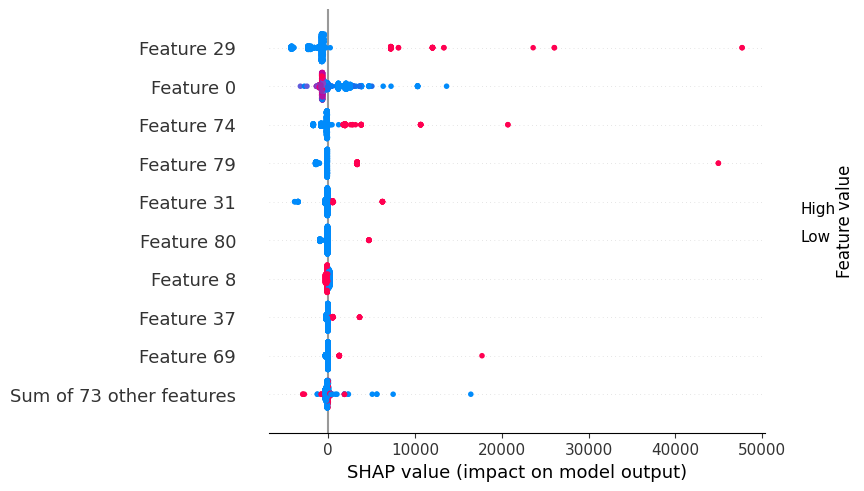

In [33]:
shap.plots.beeswarm(shap_values)

In [34]:
from sklearn.inspection import PartialDependenceDisplay

features = [0, 1, (0, 1)]

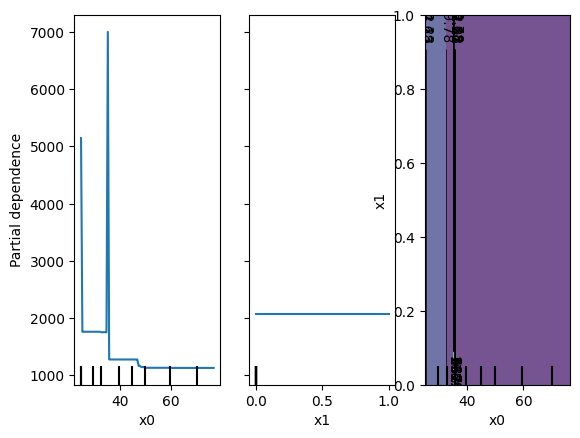

In [35]:
PartialDependenceDisplay.from_estimator(dt, X_train, features)